# K-Nearest Neighbours (Hyperparameter Tuning)

> KNN Algorithm Tuning, Grid Search, Cross Validation, Model Evaluation Metrics, Classification Report, Confusion Matrix and ROC Curve.

- toc: true 
- badges: true
- comments: true
- categories: [KNN, Hyperparameter Tuning, Machine Learning, Grid Search, Cross Validation, Model Evaluation Metrics, Classification Report, Confusion Matrix, ROC Curve]

## 1) Import libraries

### 1.1) Import libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ROCAUC, ConfusionMatrix, ClassificationReport

pd.options.mode.chained_assignment = None

## 2) Exploratory Data Analysis (EDA)

For the sake of this tutorial, we will not engage in extensive EDA. However, the visualization posts bring very detailed EDA analyses.

### 2.1) Load File

Original data source: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/leonardodecastro/data/main/winequality-white.csv')

### 2.2) Create a definition for Good Wine

In [ ]:
data['Good Wine?'] = np.where(data['quality'] < 7, 0, 1)

### 2.3) Drop original quality feature 

In [ ]:
data.drop('quality', axis=1, inplace = True)

## 3) Split and scale data

Since we will use cross validation, there is not need for a validation set.

### 3.1) Split the data frame into the training, validation and test sets

In [ ]:
# This line will disappear in the portfolio page
# Determine X and y
X = data.drop('Good Wine?', axis = 1)
y = data['Good Wine?']

# Split dataset (use the argument stratify to make sure we keep a reasonable number of both classes in the training and test sets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

### 3.2) Scale the dataset

In [ ]:
# This line will disappear in the portfolio page
# Select a type of scaler 
scaler = StandardScaler()

# Apply fit_transform on the training set and apply it to the test set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4) Hyperparameter tuning 

### 4.1) Calculate a wide range of metrics for model evaluation

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Create a dictionary to store the metrics for different k values
scores_dict = {}

# Step 2: Train model for different k values (number of neighbours)
for k in range(1, 200):
  # Part 1: Select classifier object
  knn = KNeighborsClassifier(n_neighbors=k)
  # Part 2: Determine the metrics that will be analyzed
  scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}
  # Part 3: Calculate metrics using cross-validation
  scores = cross_validate(knn, X_train_scaled, y_train, cv=5, scoring=scoring)
  # Part 4: Extract the mean of each one of the metrics
  scores_dict[k] = {'accuracy': scores['test_accuracy'].mean(), 'precision': scores['test_precision'].mean(),
                    'recall': scores['test_recall'].mean(), 'f1': scores['test_f1'].mean()}

# Step 3: Create a dataframe with model metrics
metrics_df = pd.DataFrame.from_dict(scores_dict, orient='index').rename_axis('K').reset_index()

### 4.2) Plot metrics for different k values

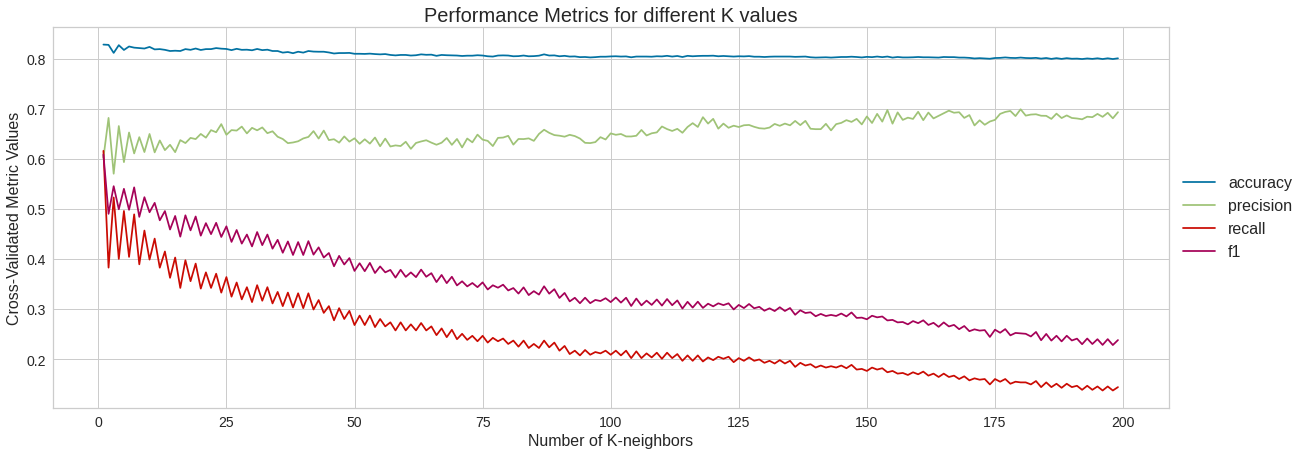

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Melt the dataframe to allow for an easy way to plot with seaborn
metrics_df_melted = pd.melt(metrics_df, id_vars =['K'], value_vars =['accuracy', 'precision','recall', 'f1'])

# Step 1: Set parameters for the visualization
plt.rcParams.update({'figure.figsize':(20,7),'axes.titlesize': 20,'axes.labelsize': 16,'xtick.labelsize': 14,'ytick.labelsize': 14})

# Step 2: Generate visualization
sns.lineplot(x="K", y="value", hue="variable", data=metrics_df_melted)
plt.title("Performance Metrics for different K values")
plt.ylabel('Cross-Validated Metric Values')
plt.xlabel('Number of K-neighbors')
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", fontsize=16)
plt.show()

### 4.3) Determine number of neighbors that optimizes precision

For the sake of this analysis, we will consider that the company at hand is a website that provides wine recommendations. Thus, the cost of recommending a bad wine is very high. This means that this firm will seek to maximize precision.

In [ ]:
ideal_number_neighbours = metrics_df.sort_values('precision', ascending = False)['K'].to_list()[0]

## 5) Evaluation of optimal model metrics

### 5.1) Classification Report, ROC Curve and Confusion Matrix 

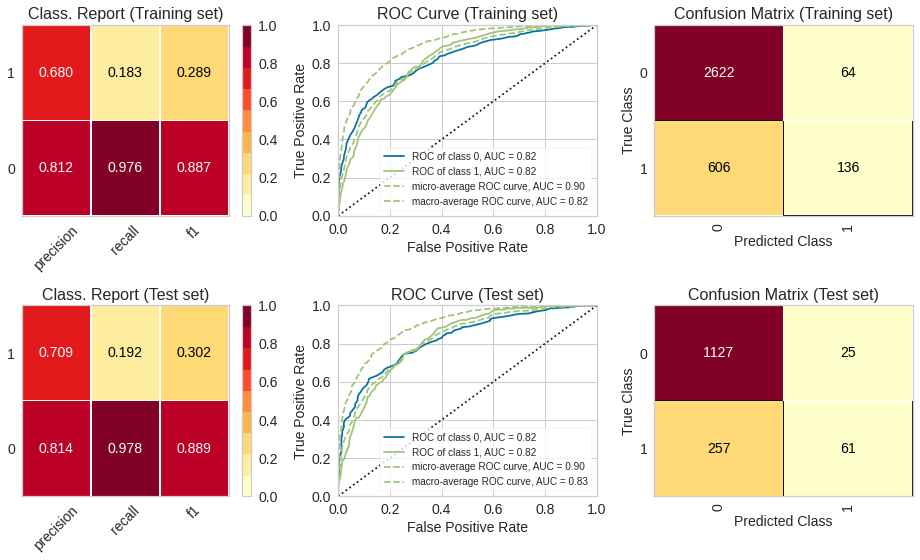

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Set the size of the figure
plt.rcParams.update({'font.size': 14,'axes.titlesize': 16,'axes.labelsize': 14,'xtick.labelsize': 14,'ytick.labelsize': 14})
fig, axes = plt.subplots(2,3, figsize=(13, 8))

# Step 2: Select the classifier
model = KNeighborsClassifier(n_neighbors=ideal_number_neighbours)

# Step 3: Create lists with the visualizers
visualizers_list_training = [ClassificationReport(model, classes=[0, 1], ax=axes[0,0], title = "Class. Report (Training set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[0,1], title = "ROC Curve (Training set)"),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[0,2], title = "Confusion Matrix (Training set)")]

visualizers_list_test = [ClassificationReport(model, classes=[0, 1], ax=axes[1,0], title = "Class. Report (Test set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[1,1], title = "ROC Curve (Test set)"),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[1,2], title = "Confusion Matrix (Test set)")]

# Step 4: Generate visualizations for the training set
for visualizer in visualizers_list_training:
  visualizer.fit(X_train_scaled, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_train_scaled, y_train)                              # Evaluate the model on the training data
  visualizer.finalize()

# Step 5: Generate visualizations for the test set
for visualizer in visualizers_list_test:
  visualizer.fit(X_train_scaled, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_test_scaled, y_test)                              # Evaluate the model on the test data
  visualizer.finalize()

We can see that the metrics for the training and test set are fairly similar, which indicates that there is **no problem with overfitting or underfitting**. Moreover, the ROC curve indicates that the classifier **outperforms a random classifier** (the baseline). 